# Purpose:
The purpose of this notebook is to find the best writers and directors based on the genres we have determined are most profitable. This is determined by doing the following:
1. Determine if writers and directors should be selected by box office numbers or critcal reception
2. Select top writers and directors for a given genre

First step is to import relevant libraries and read information from Rotten Tomatoes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

rt_movie_details_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
rt_reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='unicode_escape')

By default, box office numbers are shown as an object. We need to change these values to floats so that they can correctly be sorted by highest to lowest amounts.

In [2]:
#Need to remove commas from box office numbers, otherwise they cannot be converted to float
rt_movie_details_df['box_office'] = rt_movie_details_df['box_office'].str.replace(',','')
rt_movie_details_df['box_office'] = rt_movie_details_df['box_office'].astype('float')

By default, genres are shown as a string. This is not an issue for movies that fit into a single genre, but when there are multiple genres, it is difficult to categorize movies.

A new column is created that lists all of the individual genres listed in the genre column.

In [3]:
rt_movie_details_df['genre_list'] = rt_movie_details_df['genre'].str.split('|')


So far, our dataframe gives us information about box office, but does not give information about quality of the films. We can review our other table for review information.

In [4]:
rt_reviews_df

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
...,...,...,...,...,...,...,...,...
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"


The review dataframe has two columns that give information on quality: rating and fresh. The rating column could give us good numeric values, but the system is inconsistent and has missing values. The fresh column is consistent, but we need to convert to a number. There are two possibilities: fresh and rotten. We can assign fresh to 1 and rotten to 0, and get a mean of the scores to get the "freshness" of the movie.

In [5]:
rt_reviews_df.replace(to_replace='fresh', value=1, inplace=True)
rt_reviews_df.replace(to_replace='rotten', value=0, inplace=True)

In [6]:
rt_freshness = rt_reviews_df.groupby('id').mean()
rt_freshness.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1135 entries, 3 to 2000
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fresh       1135 non-null   float64
 1   top_critic  1135 non-null   float64
dtypes: float64(2)
memory usage: 26.6 KB


We are now ready to merge the reviews onto the main table.

In [7]:
movie_details_rated_df = rt_movie_details_df.merge(rt_freshness, how='left', left_on='id', right_on='id')
movie_details_rated_df.dropna(subset=['fresh', 'writer', 'director', 'genre_list'], inplace=True)
movie_details_rated_df['quality_ratio'] = movie_details_rated_df['box_office'] * movie_details_rated_df['fresh']
movie_details_rated_df

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,genre_list,fresh,top_critic,quality_ratio
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108 minutes,Entertainment One,"[Drama, Science Fiction and Fantasy]",0.631902,0.208589,3.791411e+05
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN,"[Drama, Musical and Performing Arts]",0.782609,0.217391,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN,"[Drama, Mystery and Suspense]",0.561404,0.333333,NaN
5,8,The year is 1942. As the Allies unite overseas...,PG,Drama|Kids and Family,Jay Russell,Gail Gilchriest,"Mar 3, 2000","Jul 11, 2000",NaN,NaN,95 minutes,Warner Bros. Pictures,"[Drama, Kids and Family]",0.746667,0.293333,NaN
6,10,Some cast and crew from NBC's highly acclaimed...,PG-13,Comedy,Jake Kasdan,Mike White,"Jan 11, 2002","Jun 18, 2002",$,41032915.0,82 minutes,Paramount Pictures,[Comedy],0.462963,0.259259,1.899672e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1547,1987,Patrick Dempsey stars in this biography of Son...,PG-13,Comedy,Phil Alden Robinson,Phil Alden Robinson,NaN,NaN,NaN,NaN,98 minutes,NaN,[Comedy],0.636364,0.090909,NaN
1551,1991,Popular rap group Run DMC stars as a trio of p...,R,Action and Adventure|Drama,Rick Rubin,Rick Rubin|Ric Menello,NaN,NaN,NaN,NaN,92 minutes,NaN,"[Action and Adventure, Drama]",0.000000,0.000000,NaN
1552,1992,"The title character, played by John Turturro, ...",R,Comedy|Drama,Joel Coen,Joel Coen|Ethan Coen,"Aug 21, 1991","May 20, 2003",NaN,NaN,116 minutes,NaN,"[Comedy, Drama]",0.905660,0.245283,NaN
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88 minutes,Paramount Vantage,"[Comedy, Science Fiction and Fantasy]",0.357143,0.321429,NaN


In [8]:
movie_details_rated_df['chosen_dir'] = rt_movie_details_df['director'].str.split('|').str[-1]
movie_details_rated_df['chosen_writ'] = rt_movie_details_df['writer'].str.split('|').str[-1]
movie_details_rated_df

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,genre_list,fresh,top_critic,quality_ratio,chosen_dir,chosen_writ
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108 minutes,Entertainment One,"[Drama, Science Fiction and Fantasy]",0.631902,0.208589,3.791411e+05,David Cronenberg,Don DeLillo
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN,"[Drama, Musical and Performing Arts]",0.782609,0.217391,NaN,Allison Anders,Allison Anders
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN,"[Drama, Mystery and Suspense]",0.561404,0.333333,NaN,Barry Levinson,Michael Crichton
5,8,The year is 1942. As the Allies unite overseas...,PG,Drama|Kids and Family,Jay Russell,Gail Gilchriest,"Mar 3, 2000","Jul 11, 2000",NaN,NaN,95 minutes,Warner Bros. Pictures,"[Drama, Kids and Family]",0.746667,0.293333,NaN,Jay Russell,Gail Gilchriest
6,10,Some cast and crew from NBC's highly acclaimed...,PG-13,Comedy,Jake Kasdan,Mike White,"Jan 11, 2002","Jun 18, 2002",$,41032915.0,82 minutes,Paramount Pictures,[Comedy],0.462963,0.259259,1.899672e+07,Jake Kasdan,Mike White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1547,1987,Patrick Dempsey stars in this biography of Son...,PG-13,Comedy,Phil Alden Robinson,Phil Alden Robinson,NaN,NaN,NaN,NaN,98 minutes,NaN,[Comedy],0.636364,0.090909,NaN,Phil Alden Robinson,Phil Alden Robinson
1551,1991,Popular rap group Run DMC stars as a trio of p...,R,Action and Adventure|Drama,Rick Rubin,Rick Rubin|Ric Menello,NaN,NaN,NaN,NaN,92 minutes,NaN,"[Action and Adventure, Drama]",0.000000,0.000000,NaN,Rick Rubin,Ric Menello
1552,1992,"The title character, played by John Turturro, ...",R,Comedy|Drama,Joel Coen,Joel Coen|Ethan Coen,"Aug 21, 1991","May 20, 2003",NaN,NaN,116 minutes,NaN,"[Comedy, Drama]",0.905660,0.245283,NaN,Joel Coen,Ethan Coen
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88 minutes,Paramount Vantage,"[Comedy, Science Fiction and Fantasy]",0.357143,0.321429,NaN,Steve Barron,Bonnie Turner


In [9]:
movie_details_rated_df.dropna(subset=['quality_ratio'], inplace=True)
movie_details_rated_df.head(2)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,genre_list,fresh,top_critic,quality_ratio,chosen_dir,chosen_writ
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108 minutes,Entertainment One,"[Drama, Science Fiction and Fantasy]",0.631902,0.208589,3.791411e+05,David Cronenberg,Don DeLillo
6,10,Some cast and crew from NBC's highly acclaimed...,PG-13,Comedy,Jake Kasdan,Mike White,"Jan 11, 2002","Jun 18, 2002",$,41032915.0,82 minutes,Paramount Pictures,[Comedy],0.462963,0.259259,1.899672e+07,Jake Kasdan,Mike White


Next, we will determine whether to choose writers and directors based on box office or critical acclaim. If scores in a given genre are typically and/or show little variance, we can recommend the studio to choose writers and directors based on box office earning, because we can score well regardless and make more money.

Conversely, if we see that scores within a genre are typically lower and/or have a higher variance, we should recommend the studio choose writers and directors based on critical acclaim. As a new studio, we want to set a good reputation, and want to avoid movies getting panned by critics.

First, we need to isolate the genres. We can do this by making a dataframe that has multiple entries for a movie if it fits into multiple genres using the explode function.

In [10]:
genre_comparison_df = movie_details_rated_df.copy()

In [11]:
genre_comparison_df['genre_single'] = genre_comparison_df['genre'].str.split('|')
genre_comparison_df = genre_comparison_df.explode('genre_single')
genre_comparison_df['genre_single'] = genre_comparison_df['genre_single'].str.strip()

In [12]:
genre_comparison_df['qual_ratio'] = genre_comparison_df['box_office'] * genre_comparison_df['fresh']

Next, we need to figure out the freshness scores for movies in a given genre. We can use these values to create box plots for each genre to see the spread of scores.

In [13]:
def freshness_scores(genre):
    df = genre_comparison_df[genre_comparison_df['genre_single'] == genre]
    scores = df['fresh'].values
    return scores

In [16]:
def director_genre_dataframe_box(genre):
    df = movie_details_rated_df[movie_details_rated_df.apply(lambda x: genre in x['genre_list'], axis=1)]
    genre_df = df.groupby('chosen_dir').mean().sort_values(by='box_office', ascending=False)
    return genre_df

In [17]:
def writer_genre_dataframe_box(genre):
    df = movie_details_rated_df[movie_details_rated_df.apply(lambda x: genre in x['genre_list'], axis=1)]
    genre_df = df.groupby('chosen_writ').mean().sort_values(by='box_office', ascending=False)
    return genre_df

In [18]:
director_genre_dataframe_box('Animation')[0:6]

,id,box_office,fresh,top_critic,quality_ratio
chosen_dir,,,,,
Gore Verbinski,1601,123188232.0,0.870270,0.178378,1.072071e+08
Fergal Reilly,667,107506776.0,0.448529,0.147059,4.821995e+07
Nick Park,1418,106604314.0,0.973684,0.250000,1.037989e+08
Greg Tiernan,1890,97661826.0,0.821622,0.178378,8.024107e+07
Steve Oedekerk,1305,72601713.0,0.222222,0.296296,1.613371e+07
Jorge Blanco,357,42194060.0,0.246575,0.246575,1.040401e+07


In [19]:
ani_directors = director_genre_dataframe_box('Animation')[0:6]

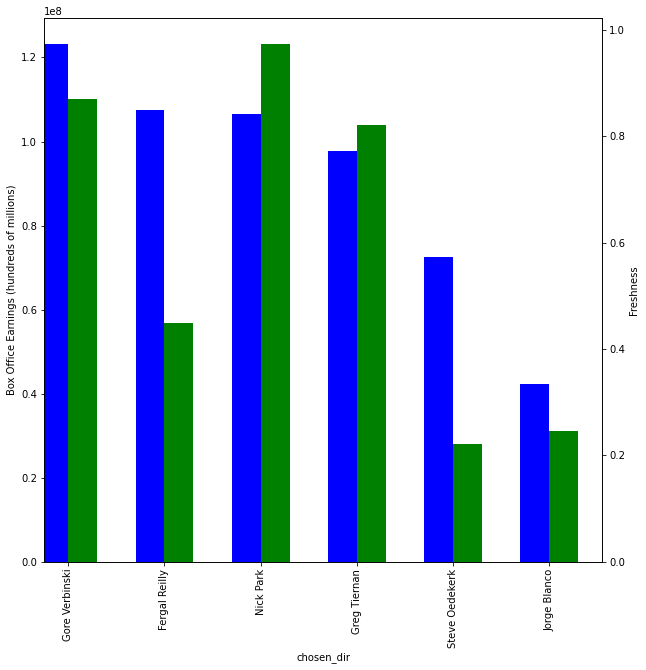

In [20]:
fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot()
ax2 = ax.twinx()

width = .3

ani_directors.box_office.plot(kind='bar', color='blue', width=width, ax=ax, position=1, align='center')
ani_directors.fresh.plot(kind='bar', color='green', width=width, ax=ax2, position=0, align='center')

ax.set_ylabel('Box Office Earnings (hundreds of millions)')
ax2.set_ylabel('Freshness')

plt.show()

In [21]:
movie_details_rated_df['box_office'].values

array([6.00000000e+05, 4.10329150e+07, 2.24114000e+05, 1.34904000e+05,
       2.05182240e+07, 1.97113500e+06, 3.12136000e+05, 2.01010000e+05,
       5.41000000e+07, 3.55659750e+07, 4.80675000e+06, 5.05192700e+06,
       1.00000000e+06, 4.29299710e+07, 1.32484770e+07, 6.40012970e+07,
       3.74314310e+07, 6.77714420e+07, 7.30232750e+07, 4.00779200e+06,
       1.62628900e+06, 3.99888900e+06, 1.25339110e+07, 2.83925600e+06,
       1.28579698e+08, 2.13181940e+07, 8.51814800e+06, 1.25835100e+07,
       3.50006290e+07, 3.73310310e+07, 1.45778000e+05, 6.34000000e+07,
       8.05740100e+07, 4.77813880e+07, 5.60000000e+06, 1.34455175e+08,
       2.59576960e+07, 3.08164000e+05, 3.27415960e+07, 1.59862720e+07,
       1.37105720e+07, 4.75653200e+06, 4.21940600e+07, 7.36673600e+06,
       8.13421700e+06, 4.19361000e+05, 1.34115100e+06, 1.21500000e+08,
       1.54485963e+08, 4.69826320e+07, 5.54000000e+07, 2.53646000e+06,
       3.96973630e+07, 2.13793150e+07, 2.92923000e+05, 4.80926000e+05,
      

In [23]:
movie_details_rated_df['box_office'].values

array([6.00000000e+05, 4.10329150e+07, 2.24114000e+05, 1.34904000e+05,
       2.05182240e+07, 1.97113500e+06, 3.12136000e+05, 2.01010000e+05,
       5.41000000e+07, 3.55659750e+07, 4.80675000e+06, 5.05192700e+06,
       1.00000000e+06, 4.29299710e+07, 1.32484770e+07, 6.40012970e+07,
       3.74314310e+07, 6.77714420e+07, 7.30232750e+07, 4.00779200e+06,
       1.62628900e+06, 3.99888900e+06, 1.25339110e+07, 2.83925600e+06,
       1.28579698e+08, 2.13181940e+07, 8.51814800e+06, 1.25835100e+07,
       3.50006290e+07, 3.73310310e+07, 1.45778000e+05, 6.34000000e+07,
       8.05740100e+07, 4.77813880e+07, 5.60000000e+06, 1.34455175e+08,
       2.59576960e+07, 3.08164000e+05, 3.27415960e+07, 1.59862720e+07,
       1.37105720e+07, 4.75653200e+06, 4.21940600e+07, 7.36673600e+06,
       8.13421700e+06, 4.19361000e+05, 1.34115100e+06, 1.21500000e+08,
       1.54485963e+08, 4.69826320e+07, 5.54000000e+07, 2.53646000e+06,
       3.96973630e+07, 2.13793150e+07, 2.92923000e+05, 4.80926000e+05,
      

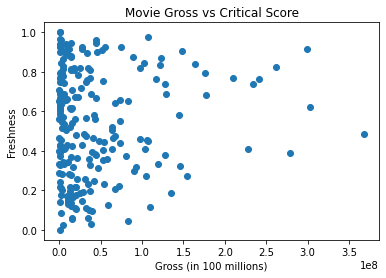

In [22]:
fig, ax = plt.subplots()

x = movie_details_rated_df['box_office'].values
y = movie_details_rated_df['fresh'].values

ax.scatter(x,y)
ax.set_title("Movie Gross vs Critical Score")
ax.set_xlabel("Gross (in 100 millions)")
ax.set_ylabel("Freshness");

In [214]:
writer_genre_dataframe_box('Animation')[0:6]

,id,box_office,fresh,top_critic,quality_ratio
chosen_writ,,,,,
John Logan,1601,123188232.0,0.870270,0.178378,1.072071e+08
Jon Vitti,667,107506776.0,0.448529,0.147059,4.821995e+07
Karey Kirkpatrick,1418,106604314.0,0.973684,0.250000,1.037989e+08
Evan Goldberg,1890,97661826.0,0.821622,0.178378,8.024107e+07
Steve Oedekerk,1305,72601713.0,0.222222,0.296296,1.613371e+07
Joe Stillman,357,42194060.0,0.246575,0.246575,1.040401e+07


In [215]:
def director_genre_dataframe_both(genre):
    df = movie_details_rated_df[movie_details_rated_df.apply(lambda x: genre in x['genre_list'], axis=1)]
    genre_df = df.groupby('chosen_dir').mean().sort_values(by='quality_ratio', ascending=False)
    return genre_df

In [216]:
def writer_genre_dataframe_both(genre):
    df = movie_details_rated_df[movie_details_rated_df.apply(lambda x: genre in x['genre_list'], axis=1)]
    genre_df = df.groupby('chosen_writ').mean().sort_values(by='quality_ratio', ascending=False)
    return genre_df

In [217]:
director_genre_dataframe_both('Science Fiction and Fantasy')[0:5]

,id,box_office,fresh,top_critic,quality_ratio
chosen_dir,,,,,
Chris Columbus,1661.500000,261835892.0,0.596377,0.239614,2.162992e+08
Peter Jackson,707.500000,303001229.0,0.765245,0.206229,1.882847e+08
Steven Spielberg,1245.666667,139720776.0,0.753018,0.149100,1.069878e+08
David Fincher,1017.000000,127490802.0,0.738739,0.180180,9.418239e+07
Alex Proyas,1935.000000,144738046.0,0.581522,0.190217,8.416832e+07


In [218]:
writer_genre_dataframe_both('Science Fiction and Fantasy')[0:5]

,id,box_office,fresh,top_critic,quality_ratio
chosen_writ,,,,,
Steve Kloves,1442.0,261835892.0,0.826087,0.212560,2.162992e+08
Fran Walsh,1136.0,303001229.0,0.621399,0.185185,1.882847e+08
David Koepp,841.0,234141872.0,0.739535,0.181395,1.731561e+08
Robin Swicord,1017.0,127490802.0,0.738739,0.180180,9.418239e+07
Jeff Vintar,1921.0,144738046.0,0.499094,0.208745,8.416832e+07


In [219]:
top_writ_ani = writer_genre_dataframe_both('Animation')[0:5]

<ipython-input-296-168e94a8238a>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
<ipython-input-296-168e94a8238a>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
<ipython-input-296-168e94a8238a>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right');


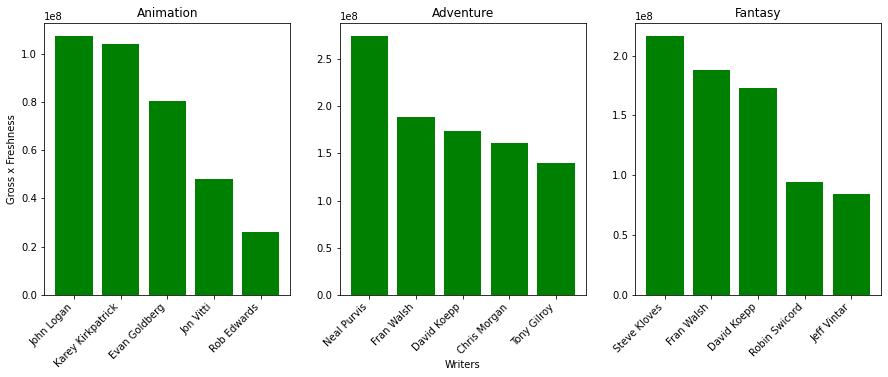

In [296]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize = (15,5))

x1 = top_writ_ani.index
height1 = top_writ_ani['quality_ratio'].values

ax1.bar(x=x1, height=height1, color='green')
ax1.set_title("Animation")
plt.draw()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_ylabel("Gross x Freshness")

x2 = top_writ_aa.index
height2 = top_writ_aa['quality_ratio'].values

ax2.bar(x=x2, height=height2, color='green')
ax2.set_title("Adventure")
ax2.set_xlabel("Writers")
plt.draw()
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

x3 = top_writ_sf.index
height3 = top_writ_sf['quality_ratio'].values

ax3.bar(x=x3, height=height3, color='green')
ax3.set_title("Fantasy")
plt.draw()
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right');

In [297]:
top_dir_ani = director_genre_dataframe_both('Animation')[0:5]
top_dir_aa = director_genre_dataframe_both('Action and Adventure')[0:5]
top_dir_sf = director_genre_dataframe_both('Science Fiction and Fantasy')[0:5]

<ipython-input-298-b7d8fece4c90>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
<ipython-input-298-b7d8fece4c90>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
<ipython-input-298-b7d8fece4c90>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right');


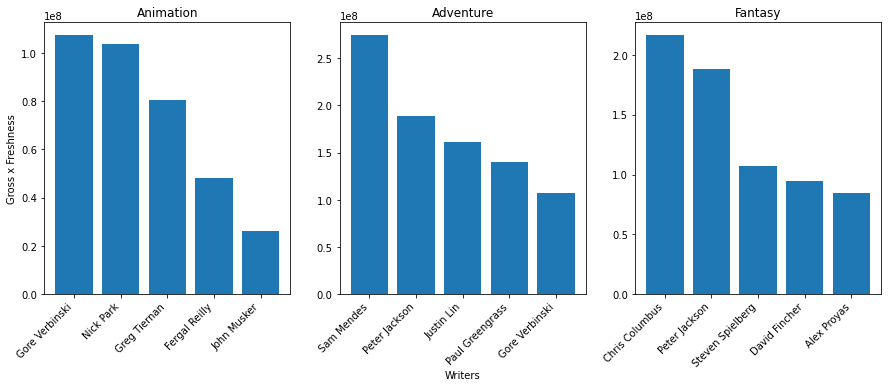

In [298]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize = (15,5))

x1 = top_dir_ani.index
height1 = top_dir_ani['quality_ratio'].values

ax1.bar(x=x1, height=height1)
ax1.set_title("Animation")
plt.draw()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_ylabel("Gross x Freshness")

x2 = top_dir_aa.index
height2 = top_dir_aa['quality_ratio'].values

ax2.bar(x=x2, height=height2)
ax2.set_title("Adventure")
ax2.set_xlabel("Writers")
plt.draw()
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

x3 = top_dir_sf.index
height3 = top_dir_sf['quality_ratio'].values

ax3.bar(x=x3, height=height3)
ax3.set_title("Fantasy")
plt.draw()
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right');

In [241]:
top_dir_ani = director_genre_dataframe_both('Animation')[0:5]

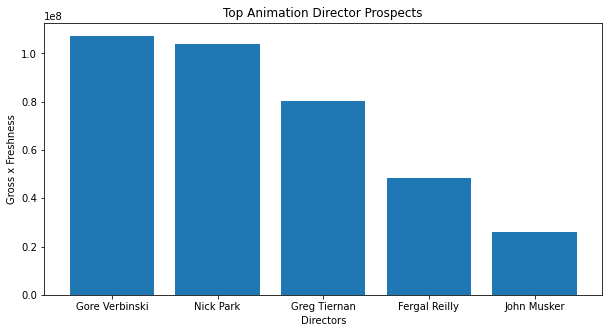

In [242]:
fig, ax = plt.subplots(figsize = (10,5))

x = top_dir_ani.index
height = top_dir_ani['quality_ratio'].values

ax.bar(x=x, height=height)
ax.set_title("Top Animation Director Prospects")
ax.set_xlabel("Directors")
ax.set_ylabel("Gross x Freshness");

In [247]:
top_writ_aa = writer_genre_dataframe_both('Action and Adventure')[0:5]

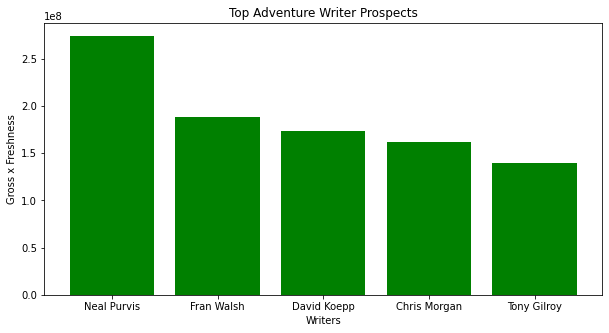

In [257]:
fig, ax = plt.subplots(figsize = (10,5))

x = top_writ_aa.index
height = top_writ_aa['quality_ratio'].values

ax.bar(x=x, height=height, color = 'green')
ax.set_title("Top Adventure Writer Prospects")
ax.set_xlabel("Writers")
ax.set_ylabel("Gross x Freshness");

In [249]:
top_writ_sf = writer_genre_dataframe_both('Science Fiction and Fantasy')[0:5]

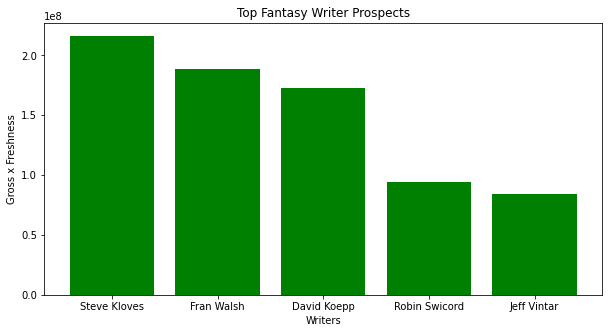

In [258]:
fig, ax = plt.subplots(figsize = (10,5))

x = top_writ_sf.index
height = top_writ_sf['quality_ratio'].values

ax.bar(x=x, height=height, color = 'green')
ax.set_title("Top Fantasy Writer Prospects")
ax.set_xlabel("Writers")
ax.set_ylabel("Gross x Freshness");

In [251]:
top_dir_aa = director_genre_dataframe_both('Action and Adventure')[0:5]

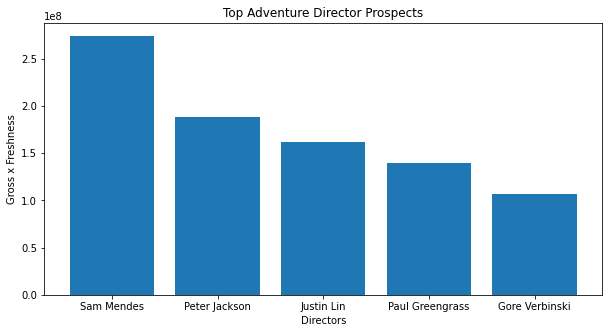

In [252]:
fig, ax = plt.subplots(figsize = (10,5))

x = top_dir_aa.index
height = top_dir_aa['quality_ratio'].values

ax.bar(x=x, height=height)
ax.set_title("Top Adventure Director Prospects")
ax.set_xlabel("Directors")
ax.set_ylabel("Gross x Freshness");

In [253]:
top_dir_sf = director_genre_dataframe_both('Science Fiction and Fantasy')[0:5]

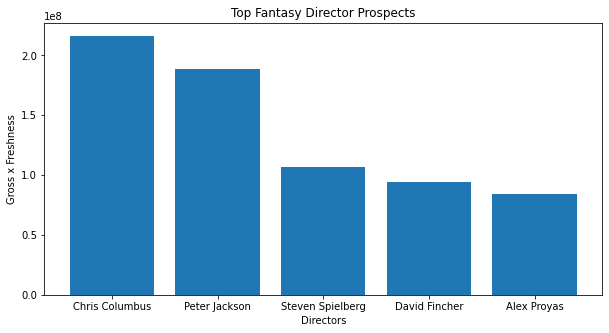

In [254]:
fig, ax = plt.subplots(figsize = (10,5))

x = top_dir_sf.index
height = top_dir_sf['quality_ratio'].values

ax.bar(x=x, height=height)
ax.set_title("Top Fantasy Director Prospects")
ax.set_xlabel("Directors")
ax.set_ylabel("Gross x Freshness");